# Revisiting Lambert’s problem in Python

The Izzo algorithm to solve the Lambert problem is available in poliastro and was implemented from this paper: https://docs.poliastro.space/en/stable/examples/Revisiting%20Lamberts%20problem%20in%20Python.html#:~:text=was%20implemented%20from-,this%20paper,-.

In [1]:
from cycler import cycler

from matplotlib import pyplot as plt
import numpy as np

from poliastro.core import iod
from poliastro.iod import izzo

## Part 1: Reproducing the original figure

In [3]:
x = np.linspace(-1, 2, num=1000)
M_list = 0, 1, 2, 3
ll_list = 1, 0.9, 0.7, 0, -0.7, -0.9, -1

Text(0, 0.5, '$T$')

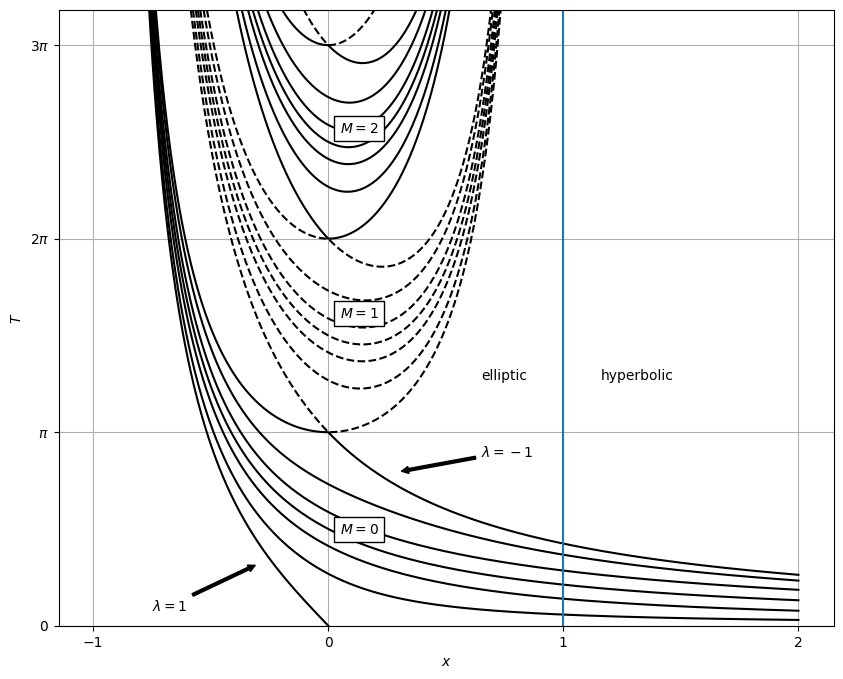

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_prop_cycle(
    cycler("linestyle", ["-", "--"])
    * (cycler("color", ["black"]) * len(ll_list))
)
for M in M_list:
    for ll in ll_list:
        T_x0 = np.zeros_like(x)
        for ii in range(len(x)):
            y = iod._compute_y(x[ii], ll)
            T_x0[ii] = iod._tof_equation_y(x[ii], y, 0.0, ll, M)
        if M == 0 and ll == 1:
            T_x0[x > 0] = np.nan
        elif M > 0:
            # Mask meaningless solutions
            T_x0[x > 1] = np.nan
        (l,) = ax.plot(x, T_x0)

ax.set_ylim(0, 10)

ax.set_xticks((-1, 0, 1, 2))
ax.set_yticks((0, np.pi, 2 * np.pi, 3 * np.pi))
ax.set_yticklabels(("$0$", "$\pi$", "$2 \pi$", "$3 \pi$"))

ax.vlines(1, 0, 10)
ax.text(0.65, 4.0, "elliptic")
ax.text(1.16, 4.0, "hyperbolic")

ax.text(0.05, 1.5, "$M = 0$", bbox=dict(facecolor="white"))
ax.text(0.05, 5, "$M = 1$", bbox=dict(facecolor="white"))
ax.text(0.05, 8, "$M = 2$", bbox=dict(facecolor="white"))

ax.annotate(
    "$\lambda = 1$",
    xy=(-0.3, 1),
    xytext=(-0.75, 0.25),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)
ax.annotate(
    "$\lambda = -1$",
    xy=(0.3, 2.5),
    xytext=(0.65, 2.75),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)

ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$T$")

## Part 2: Locating 𝑇𝑚𝑖𝑛

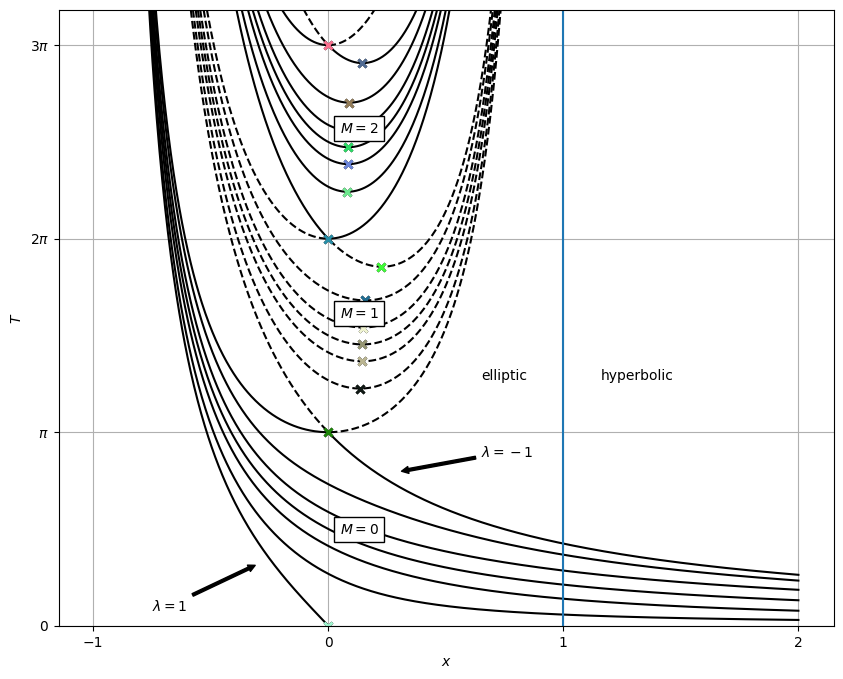

In [23]:
for M in M_list:
    for ll in ll_list:
        x_T_min, T_min = iod._compute_T_min(ll, M, 10, 1e-8)
        ax.plot(x_T_min, T_min, "kx", mew=2)
        # add random color to the marker
        ax.plot(x_T_min, T_min, "x", mew=2, color=np.random.rand(3,))

fig

## Part 3: Try out solution

In [6]:
T_ref = 1
ll_ref = 0

x_ref, _ = iod._find_xy(
    ll_ref, T_ref, M=0, numiter=10, lowpath=True, rtol=1e-8
)
x_ref

0.4334467345350424

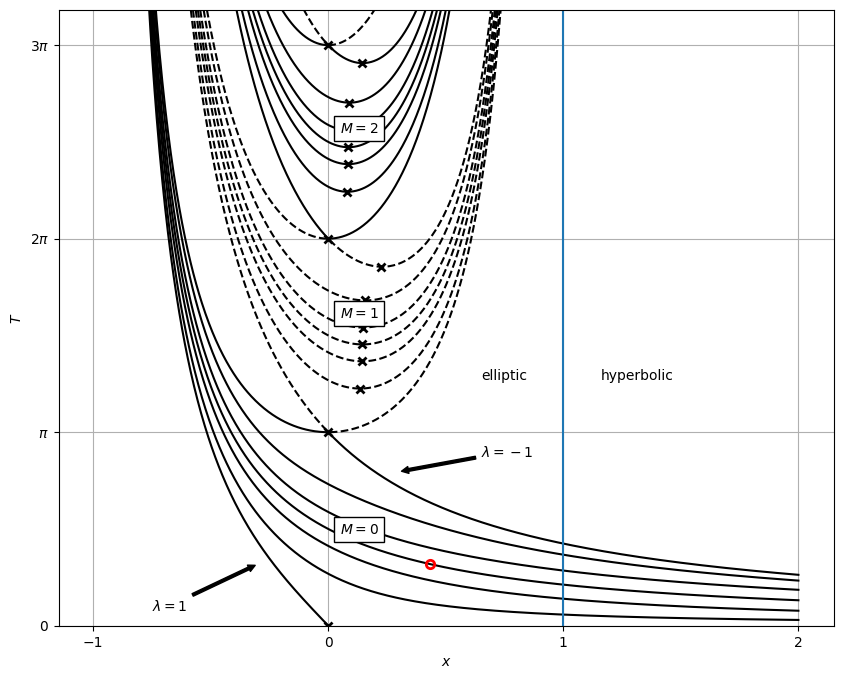

In [7]:
ax.plot(x_ref, T_ref, "o", mew=2, mec="red", mfc="none")

fig

## Part 4: Run some examples

In [8]:
from astropy import units as u

from poliastro.bodies import Earth

### Single revolution

In [9]:
k = Earth.k
r0 = [15945.34, 0.0, 0.0] * u.km
r = [12214.83399, 10249.46731, 0.0] * u.km
tof = 76.0 * u.min

expected_va = [2.058925, 2.915956, 0.0] * u.km / u.s
expected_vb = [-3.451569, 0.910301, 0.0] * u.km / u.s

v0, v = izzo.lambert(k, r0, r, tof)
v

<Quantity [-3.4515665 ,  0.91031354,  0.        ] km / s>

In [10]:
k = Earth.k
r0 = [5000.0, 10000.0, 2100.0] * u.km
r = [-14600.0, 2500.0, 7000.0] * u.km
tof = 1.0 * u.h

expected_va = [-5.9925, 1.9254, 3.2456] * u.km / u.s
expected_vb = [-3.3125, -4.1966, -0.38529] * u.km / u.s

v0, v = izzo.lambert(k, r0, r, tof)
v

<Quantity [-3.3124585 , -4.19661901, -0.38528906] km / s>

### Multiple revolutions

In [11]:
k = Earth.k
r0 = [22592.145603, -1599.915239, -19783.950506] * u.km
r = [1922.067697, 4054.157051, -8925.727465] * u.km
tof = 10 * u.h

expected_va = [2.000652697, 0.387688615, -2.666947760] * u.km / u.s
expected_vb = [-3.79246619, -1.77707641, 6.856814395] * u.km / u.s

expected_va_l = [0.50335770, 0.61869408, -1.57176904] * u.km / u.s
expected_vb_l = [-4.18334626, -1.13262727, 6.13307091] * u.km / u.s

expected_va_r = [-2.45759553, 1.16945801, 0.43161258] * u.km / u.s
expected_vb_r = [-5.53841370, 0.01822220, 5.49641054] * u.km / u.s

In [12]:
v0, v = izzo.lambert(k, r0, r, tof, M=0)
v

<Quantity [-3.79246619, -1.77707641,  6.85681439] km / s>

In [13]:
_, v_l = izzo.lambert(k, r0, r, tof, M=1, lowpath=True)
_, v_r = izzo.lambert(k, r0, r, tof, M=1, lowpath=False)

In [14]:
v_l

<Quantity [-5.53841318,  0.01822213,  5.49641016] km / s>

In [15]:
v_r

<Quantity [-4.18334626, -1.13262727,  6.13307091] km / s>